<a href="https://colab.research.google.com/github/cnovak232/DL_Speech_Enhancement/blob/segan/gan_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/cnovak232/DL_Speech_Enhancement.git

Cloning into 'DL_Speech_Enhancement'...
remote: Enumerating objects: 16503, done.
remote: Counting objects: 100% (5823/5823), done.
remote: Compressing objects: 100% (5797/5797), done.
remote: Total 16503 (delta 31), reused 5811 (delta 25), pack-reused 10680
Receiving objects: 100% (16503/16503), 3.44 GiB | 25.61 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Updating files: 100% (16398/16398), done.


In [2]:
!pip install PyWavelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Define some helper function for plotting and playing audio

In [3]:
import torch
import torchaudio as ta
import librosa as lib
from IPython.display import Audio, display
import matplotlib
import matplotlib.pyplot as plt
import pywt

# helper functions for audio and what not
# mostly taken for torchaudio tutorials 

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)

    figure.suptitle(title)
    plt.show(block=False)

def get_spectrogram(
    waveform = None,
    n_fft = 512,
    win_len = None,
    hop_len = None,
    power = 1.0 ):
    spectrogram = ta.transforms.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power )
    
    return spectrogram(waveform)

def plot_spectrogram(spec, type = "amplitude", title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    toDb = ta.transforms.AmplitudeToDB(type)
    im = axs.imshow(toDb(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


class DWT(object):
    def __init__(self, name, level):
        self.name = name
        self.level = level

    def __call__(self, x):
        coeffs = pywt.wavedec(x, self.name, level=self.level,mode='per')
        xdwt = torch.empty(0)
        for band in coeffs:
            torch.from_numpy(band)
            xdwt = torch.cat( (xdwt, torch.from_numpy(band)), dim=1)
        return xdwt

class IDWT(object):
    def __init__(self, name, level):
        self.name = name
        self.level = level

    def __call__(self, xdwt):
        length = xdwt.shape[1]
        coeffs = []
        for idx in range(self.level):
            hlen = length // 2
            coeffs.append( xdwt[:,hlen:length].numpy() )
            length = hlen

        coeffs.append( xdwt[:,:length].numpy() )
        coeffs.reverse()

        xr = pywt.waverec(coeffs, self.name, mode='per')
        return torch.from_numpy(xr) 

def norm_spec( spec ):
    return spec, 1
    #normed = spec / spec.max()
    #return normed, spec.max()

Define a Custom Dataset class for the Data and read it in

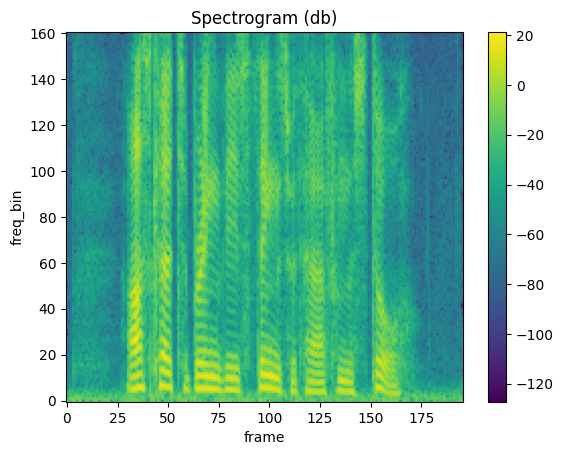

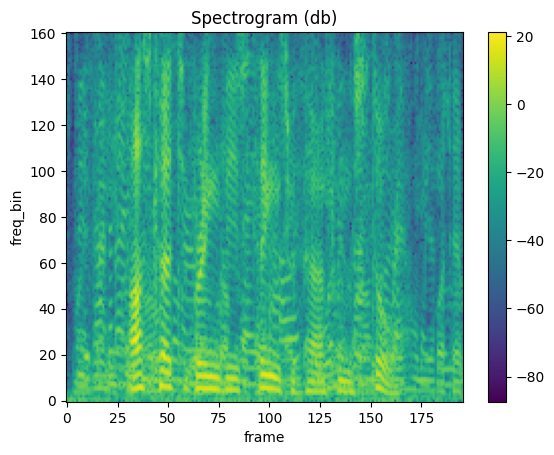

In [4]:
# read dataset in and downsample / transform / pad if needed
from torch.utils.data import Dataset
import torch
import os

class VoiceBankDemand(Dataset):
    def __init__(self, clean_dir, noisy_dir, list_dir, 
                 data = "train", len_samples = None, downsample = None, 
                 transform = None ):
        self.clean_dir = clean_dir
        self.noisy_dir = noisy_dir
        self.list_dir = list_dir
        self.num_samples = len_samples
        self.downsample = downsample
        self.transform = transform
        self.data = data
    
    def __len__(self):
        return len(self.list_dir)

    def __getitem__( self, idx ):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        clean_name = os.path.join( self.clean_dir, self.list_dir[idx] )
        noisy_name = os.path.join( self.noisy_dir, self.list_dir[idx] )
        clean_audio, fs = ta.load(clean_name)
        noisy_audio, fs= ta.load(noisy_name)

        if self.downsample:
            downsampler = ta.transforms.Resample(fs,self.downsample)
            clean_audio = downsampler( clean_audio )
            noisy_audio = downsampler( noisy_audio )

        orig_len = clean_audio.shape[1]

        if self.num_samples:
            # trim or pad audio to fixed length 
            if clean_audio.shape[1] > num_samples:
                clean_audio = clean_audio[:,:num_samples]
                noisy_audio = noisy_audio[:,:num_samples]
            elif clean_audio.shape[1] < num_samples:
                pad_len = int( num_samples - clean_audio.shape[1] )
                pad = torch.zeros(1,pad_len)
                clean_audio = torch.cat((clean_audio,pad), dim=1)
                noisy_audio = torch.cat((noisy_audio,pad),dim=1)
        
        if self.data == "test":
            if self.transform:
                noisy_audio = self.transform( noisy_audio )
                clean_audio = self.transform( clean_audio )
                #clean_mag,_ = torch.abs(clean_trnsfrm) 
                #clean_audio = (clean_audio, clean_mag)
               # noisy_mag, norm_val = torch.abs(noisy_trnsfrm)
                #noisy_phase = torch.angle(noisy_trnsfrm)
                #noisy_audio = (noisy_mag, noisy_phase, noisy_audio, norm_val)
        else:
            if self.transform:
                clean_audio  = self.transform( clean_audio )
                noisy_audio  = self.transform( noisy_audio ) 

        sample = (clean_audio, noisy_audio, orig_len)

        return sample

train_clean_path = './DL_Speech_Enhancement/clean_trainset_28spk_wav'
train_noisy_path = './DL_Speech_Enhancement/noisy_trainset_28spk_wav'
test_clean_path  = './DL_Speech_Enhancement/clean_testset_wav'
test_noisy_path  = './DL_Speech_Enhancement/noisy_testset_wav'

#sort both clean training and testing data
list_dir_train = os.listdir(train_clean_path)
list_dir_train.sort()
list_dir_test = os.listdir(test_clean_path)
list_dir_test.sort()

target_fs = 8000 # downsample to 16 KHz
spectrogram = ta.transforms.Spectrogram(
    n_fft=320, # size for the CRNN
    power=1.0,
    normalized = False )

WAVE_UNET_LEN = 16384 # length the WaveUNET processing
num_samples = WAVE_UNET_LEN * 3


wavelet = DWT( name = 'db8', level = 5 )


# return turns a tuple of ( clean_data,noisy_data,original_length)
# data type depends on if transform was specified
train_set = VoiceBankDemand( clean_dir = train_clean_path,
                             noisy_dir = train_noisy_path,
                             list_dir = list_dir_train,
                             len_samples = None, # clip or pad samples to be 5s
                             downsample = target_fs, # downsample to 16Khz
                             transform = spectrogram )

# returns tuples within tuples: clean_data, noisy_data, original length
# If using a transform (like spectrogram) the subtuples will be:
# clean_data: (clean_waveform, clean_spec)
# noisy_data: ( noisy_spec, noisy_phase, noisy_waveform, normalization_val )
test_set = VoiceBankDemand( clean_dir = test_clean_path,
                            noisy_dir = test_noisy_path,
                            list_dir = list_dir_test,
                            data = "test",
                            len_samples = None,
                            downsample = target_fs,
                            transform = spectrogram )

#############################################################
# for viewing samples and such
clean, noisey, orgin_len = train_set[1]

#transform = DWT( name = 'db4', level = 3 )
#inv_transform = IDWT( name = 'db4', level = 3)
#clean_dwt = transform(clean)


#cleanr = inv_transform(clean_dwt)

#plot_waveform(clean_dwt,target_fs)
#plot_waveform(cleanr,target_fs)

clean_test, noisy_test, orig_len = test_set[0]

#noisy_mag, noisy_phase, noisy_audio, norm_val = noisy_test

plot_spectrogram(clean.squeeze())
plot_spectrogram(noisey.squeeze())

#play_audio(noisy_audio[:,:orig_len],target_fs)

In [29]:
train_set[0]

(tensor([[[1.2946e-01, 8.3714e-01, 5.2215e-01,  ..., 3.1410e-01,
           1.5350e-01, 1.4986e-01],
          [3.8727e-02, 6.6881e-01, 5.8127e-01,  ..., 2.2001e-01,
           2.5494e-01, 5.6804e-02],
          [1.1463e-01, 2.3115e-01, 2.8065e-01,  ..., 7.7669e-02,
           2.8812e-01, 1.1240e-02],
          ...,
          [5.9582e-03, 4.2178e-03, 7.4756e-03,  ..., 1.9350e-03,
           3.8969e-03, 3.1218e-03],
          [1.8482e-03, 5.9964e-04, 5.3254e-03,  ..., 3.6260e-03,
           3.1290e-03, 1.2360e-03],
          [6.0551e-03, 1.2768e-03, 4.7498e-03,  ..., 2.1581e-03,
           5.2023e-03, 3.9625e-04]]]),
 tensor([[[3.1314e-02, 7.1600e-01, 5.8214e-01,  ..., 4.8272e-01,
           3.0895e-02, 1.3199e-01],
          [8.5918e-02, 5.8937e-01, 6.2424e-01,  ..., 3.1628e-01,
           2.6066e-01, 7.3196e-02],
          [9.8928e-04, 2.7528e-01, 3.9439e-01,  ..., 1.3633e-01,
           3.5700e-01, 2.8501e-01],
          ...,
          [5.9368e-03, 3.7730e-03, 2.5474e-03,  ..., 3.716

In [5]:
#the following code will be based on this website https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [6]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [28]:
import tensorflow as tf
for i in train_set:
  print(len(i))

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


KeyboardInterrupt: ignored

In [19]:
print(next(iter(dataloader)))

RuntimeError: ignored

In [7]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [8]:
# Plot some training images
#real_batch = next(iter(dataloader))
#plt.figure(figsize=(8,8))
#plt.axis("off")
#plt.title("Training Images")
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
import torch
import torch.nn as nn
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [13]:
import torch.optim as optim
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
for i, data in enumerate(dataloader, 0):
  print("i")
  print(i)
  print("data")
  print(data)
  

RuntimeError: ignored

In [16]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


RuntimeError: ignored

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()